### Daytum Course: Spatial Data Analytics

#### Spatial Simulation

Demonstration of reservoir property simulation.

#### Description

Here's a simple, documented workflow, demonstration of reservoir property spatial simulation for subsurface modeling workflows. This should help you get started with building subsurface models that integrate machine learning to integrate data sources. 

Here's a simple workflow for spatial simulation with SGSIM. This method is ciritical for:

* Building spatial models that honor the univariate and spatial distribution of the property of interest 

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.GSLIB as GSLIB

In [ ]:
We will also need some standard packages. These should have been installed with Anaconda 3.

In [ ]:
ignore_warnings = True                                    # ignore warnings?
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import matplotlib as mpl                                  # custom colorbar
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
plt.rc('axes', axisbelow=True)                            # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                     # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Define Functions

This is a convenience function to add major and minor gridlines and a combine location map and pixelplot that has color maps and color bars to improve plot interpretability.

In [2]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks  
    
def locpix_colormaps_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel_loc,vlabel,cmap_loc,cmap):
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )
    cs = plt.imshow(array,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
    plt.scatter(df[xcol],df[ycol],s=None,c=df[vcol],marker=None,cmap=cmap_loc,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,
        edgecolors="black",)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    cbar_loc = plt.colorbar(orientation="vertical",pad=0.08,ticks=[0, 1],
            format=mticker.FixedFormatter(['Shale','Sand'])); cbar_loc.set_label(vlabel_loc, rotation=270,labelpad=20)
    cbar = plt.colorbar(cs,orientation="vertical",pad=0.05); cbar.set_label(vlabel, rotation=270,labelpad=20)
    return cs

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [3]:
#os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load the data into a Pandas' DataFrame object. You can select one of the following datasets with command,

````python 
idata = 0
````

| Index       | Name             | Description                                                  |
|:-----------:|:------------------:|:--------------------------------------------------------------:|
| 0           | sample_data_biased | biased with moderate covered and one section dense, regular sampling | 
| 1           | spatial_nonlinear_MV_facies_v1 | biased with dense sampling | 
| 2           | spatial_nonlinear_MV_facies_v5_sand_only | biased sand only | 
| 3           | 12_sample_data.csv | biased sparsely sampled | 
| 4           | sample_data.csv | regular sampling 2 densely sampled study areas | 

In [10]:
idata = 0

if idata == 0:
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load the data from Dr. Pyrcz's github repository
    pormax = 0.24
if idata == 1:
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
    df['Porosity'] = df['Porosity']/100.0
    pormax = 0.24
if idata == 2:    
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v5_sand_only.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
    df['Porosity'] = df['Porosity']/100.0
    pormax = 0.30
if idata == 3:    
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
    df = df.sample(n = 40)
    pormax = 0.30
if idata == 4:    
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
#     df = df.sample(n = 40)
    pormax = 0.30

Note, for brevity, we work with all facies together.

* in typically workflows we work by-based and combine the models

#### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with a test, comparision of simulation with simple and ordinary kriging.


 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
                 Weighted Average              = 0.1347
                 Weighted Variance             = 0.0014
                 Weighted Transformed Average  = 0.0011
                 Weighted Transformed Variance = 1.0004
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2976 (close to 0.0?)
                                   variance = 0.8678 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
  

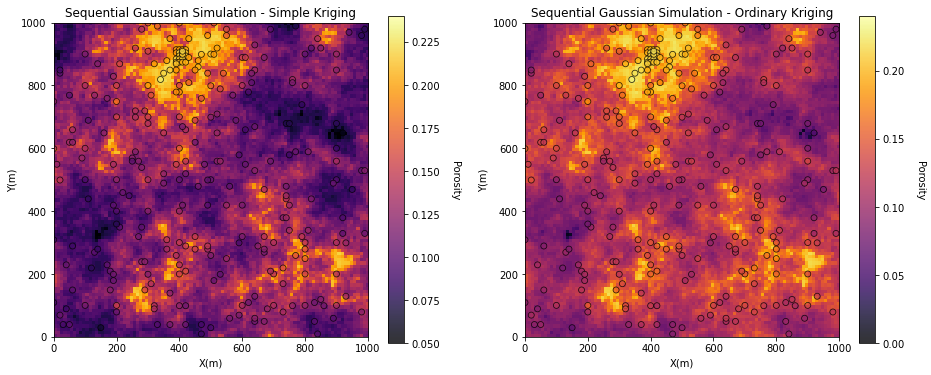

In [12]:
run_model = True

# Simple Kriging vs. Ordinary Kriging
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20;
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=200,hmin1=200)
tmin = -999; tmax = 999

if run_model == True:
    sim_sk = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario)[0]

    sim_ok = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=30,mults=0,nmult=2,noct=-1,ktype=1,colocorr=0.0,sec_map=0,vario=vario)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_sk,xmin,xmax,ymin,ymax,xsiz,0.05,0.24,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation - Simple Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplot(222)
GSLIB.locpix_st(sim_ok,xmin,xmax,ymin,ymax,xsiz,0.0,pormax,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation - Ordinary Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2); plt.show()

#### Exploring Geometric Anisotropy

Let's look at 1 realization of porosity all with short range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
                 Weighted Average              = 0.1347
                 Weighted Variance             = 0.0014
                 Weighted Transformed Average  = 0.0011
                 Weighted Transformed Variance = 1.0004
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1577 (close to 0.0?)
                                   variance = 0.9766 (close to gammabar(V,V)? approx. 1.0)


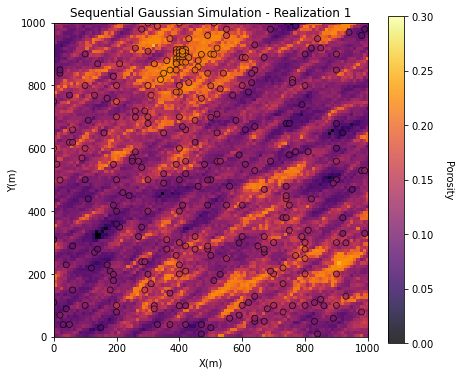

In [14]:
# Strongly Anisotropic Realization
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 200; ktype = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=200,hmin1=50)
tmin = -999; tmax = 999

sim_anis = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1, ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim_anis,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2); plt.show()

#### Exploring Multiple Realizations

Let's look at 4 realizations of porosity all with short range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
                 Weighted Average              = 0.1347
                 Weighted Variance             = 0.0014
                 Weighted Transformed Average  = 0.0011
                 Weighted Transformed Variance = 1.0004
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0166 (close to 0.0?)
                                   variance = 0.9934 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
  

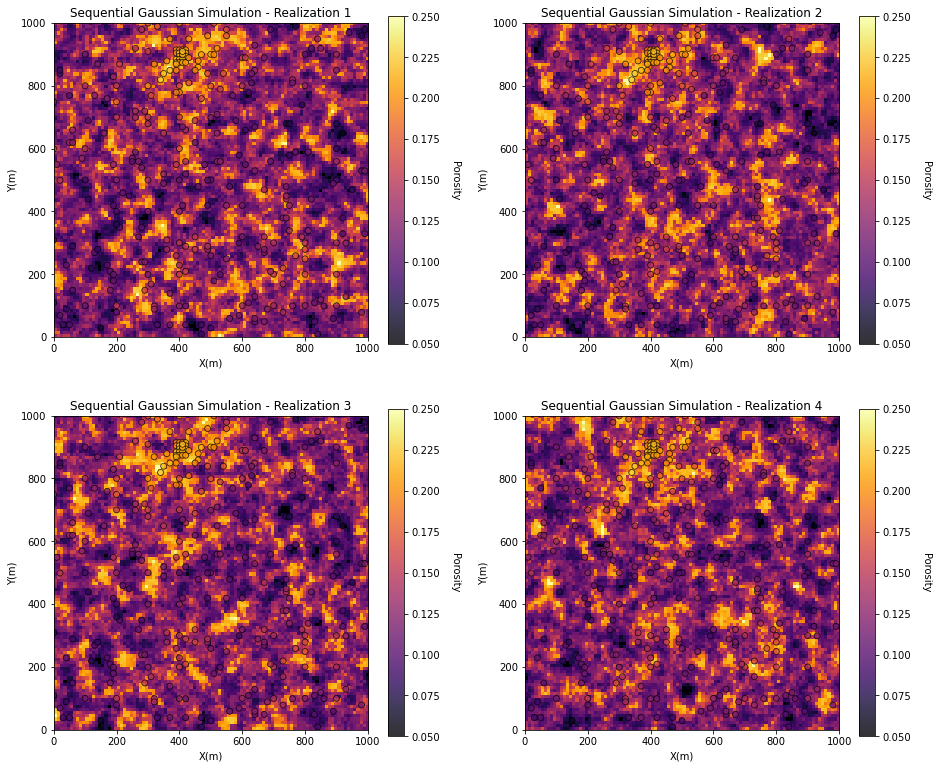

In [15]:
# Demonstration of Multiple Realizations - Short Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 5; radius = 50; ktype = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=50,hmin1=50)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

sim4 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2); plt.show()

Let's look at 4 realizations of porosity all with long range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
                 Weighted Average              = 0.1347
                 Weighted Variance             = 0.0014
                 Weighted Transformed Average  = 0.0011
                 Weighted Transformed Variance = 1.0004
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.3334 (close to 0.0?)
                                   variance = 0.7377 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
  

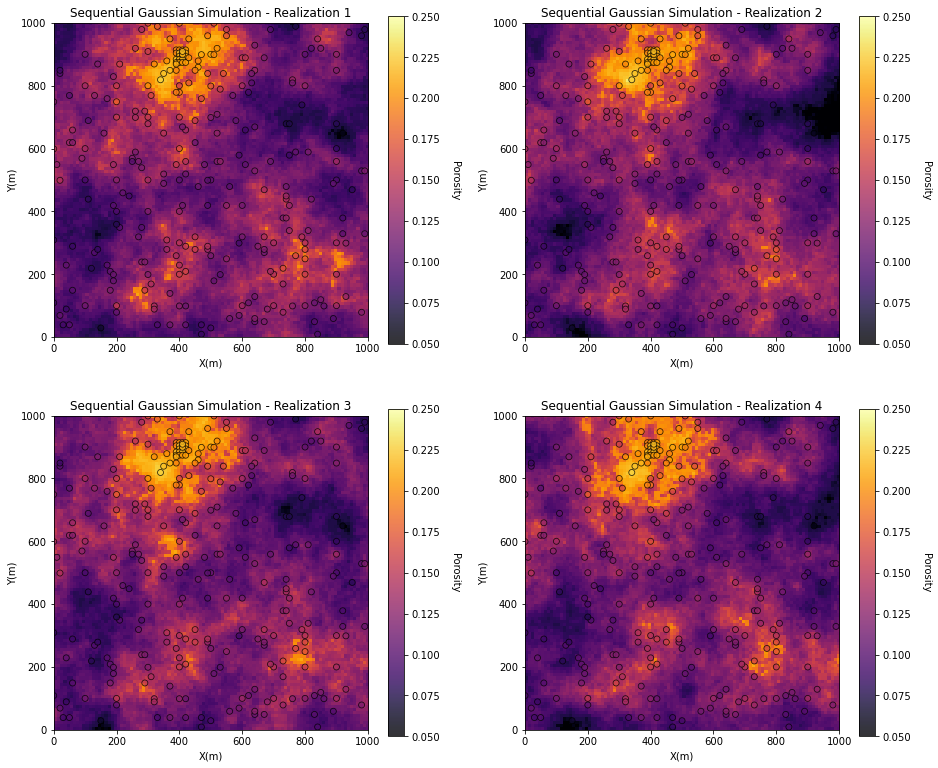

In [16]:
# Demonstration of Multiple Realizations - Long Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 5; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=500,hmin1=500)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

sim4 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Sequential Gaussian Simulation - Collocated Cokriging

Now let's demonstrate collocated cokriging.  We first calculate a realization of porosity and then collocated cokriging realization of permeability constrained to the porosity realizations.


 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
                 Weighted Average              = 0.1347
                 Weighted Variance             = 0.0014
                 Weighted Transformed Average  = 0.0011
                 Weighted Transformed Variance = 1.0004
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.157 (close to 0.0?)
                                   variance = 0.9436 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 289
                 Number trimmed                = 0
   

KeyError: 'logPerm'

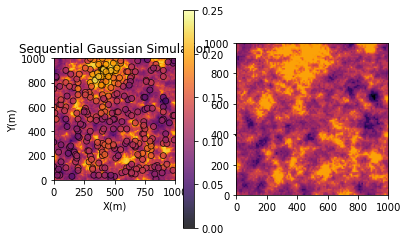

In [17]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 5; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=100,hmin1=100)
tmin = -99999; tmax = 99999

trend = np.zeros((ny,nx))
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix] = -1*(iy-ny/2)/(ny)*0.03+.127
#trend = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]) 
    
sim_por = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=trend,vario=vario)[0]

sim_perm = geostats.sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1000.0,ltail=1,ltpar=0.0,utail=1,utpar=1000.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=4,colocorr=0.9,sec_map=sim_por,vario=vario)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(121)
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,0.0,0.250,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation','X(m)','Y(m)','Porosity',cmap)
sim_log_perm = np.log(sim_perm.clip(0.0001,1200))
plt.subplot(122)
GSLIB.locpix_st(sim_log_perm,xmin,xmax,ymin,ymax,xsiz,-5.0,10,df,'X','Y','logPerm',
                'Sequential Gaussian Simulation Collocated Cokriging','X(m)','Y(m)','Permeabilty Log(mD)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration spatial simulation.
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>